In [71]:
import numpy as np 
import pandas as pd
import sklearn

import os

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from plotnine import *

In [73]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [74]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV

In [75]:
in_trainData = pd.read_csv("./data/train.csv")
testData = pd.read_csv("./data/test.csv")

In [76]:
in_trainData.shape

(1460, 81)

In [77]:
testData.shape

(1459, 80)

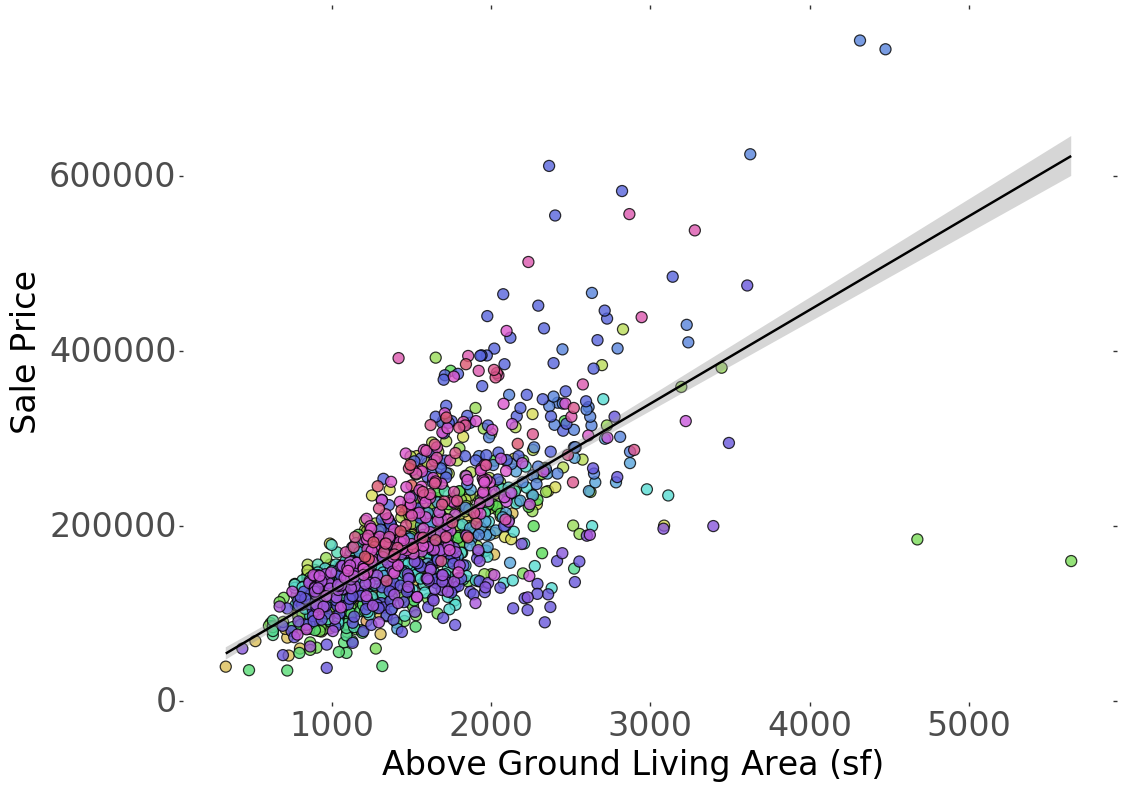

<ggplot: (-9223363282939457143)>

In [78]:
(ggplot(in_trainData,aes(x="GrLivArea",y="SalePrice")) + 
 geom_point(mapping=aes(fill="Neighborhood"),color="black",size=4,alpha=0.8) + 
 geom_smooth(method = "lm") + 
 xlab("Above Ground Living Area (sf)") + ylab("Sale Price") + 
 #ggtitle("Sale Price Against Ground Floor Living Area Colored by Neighborhood") +
 theme(legend_position="none",
       text = element_text(size=24),
      panel_background=element_rect(fill="white"),
      figure_size=(12,9)))

In [79]:
outliers = ((in_trainData.GrLivArea > 4000) & (in_trainData.SalePrice < 5E5))
trainData = in_trainData[~(outliers)]

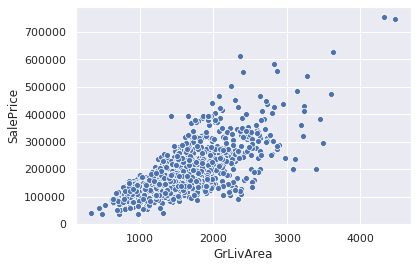

In [80]:
sns.scatterplot(data=trainData,x="GrLivArea",y="SalePrice")

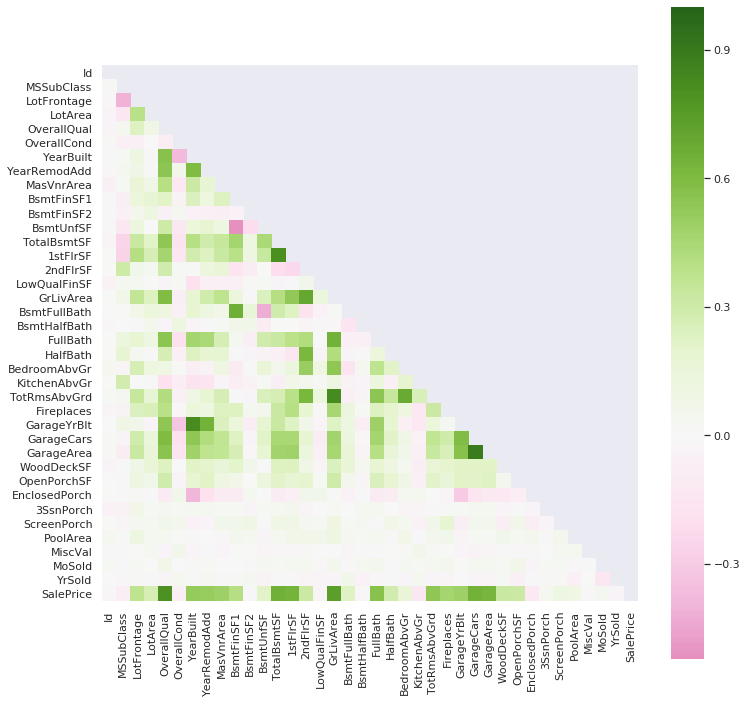

In [81]:
f, ax = plt.subplots(figsize=(12, 12))
corr = trainData.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(trainData.corr(), mask=mask, square=True,cmap="PiYG",center=0)

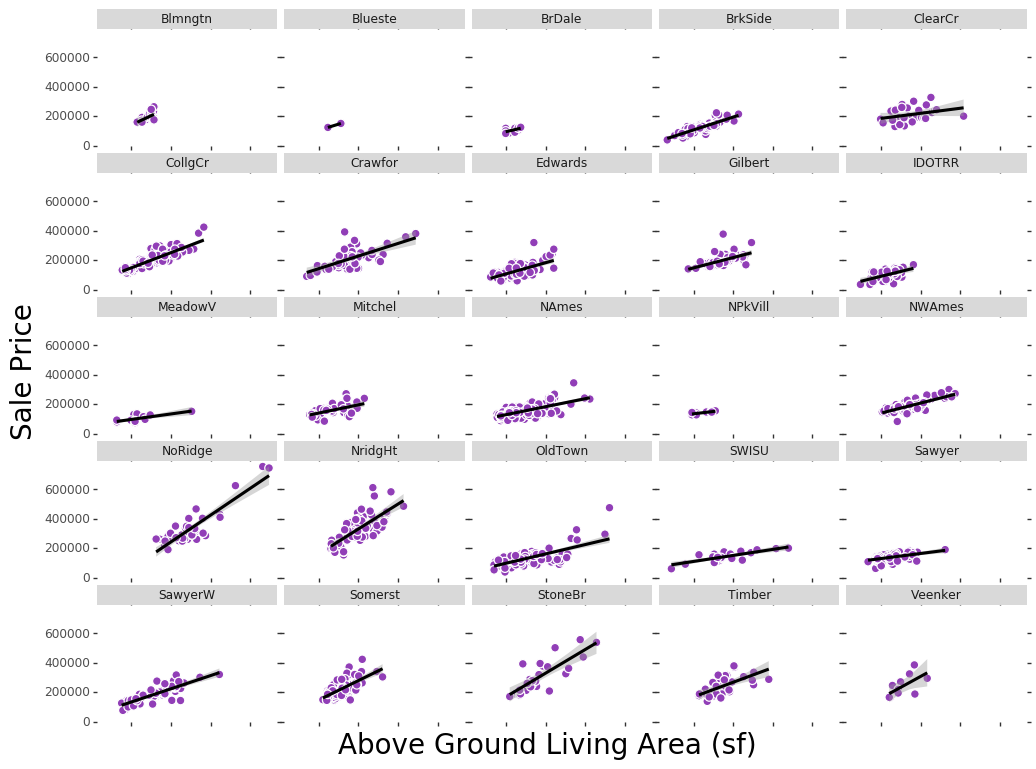

<ggplot: (8753907782639)>

In [109]:
(ggplot(trainData,aes(x="GrLivArea",y="SalePrice")) + geom_point(fill="#913eb7",color="white",size=3) + 
geom_smooth(method='lm',size=1.25) + 
facet_wrap("Neighborhood") +
xlab("Above Ground Living Area (sf)") + ylab("Sale Price") + 
theme(legend_position="none",
       axis_title_y = element_text(size=20),
       axis_title_x = element_text(size=20),
       axis_text_x = element_blank(),
      panel_background=element_rect(fill="white"),
      figure_size=(12,9)))

In [110]:
trainData["logSP"] = np.log(trainData.SalePrice)

Text(0.5, 0, 'log(Sale Price)')

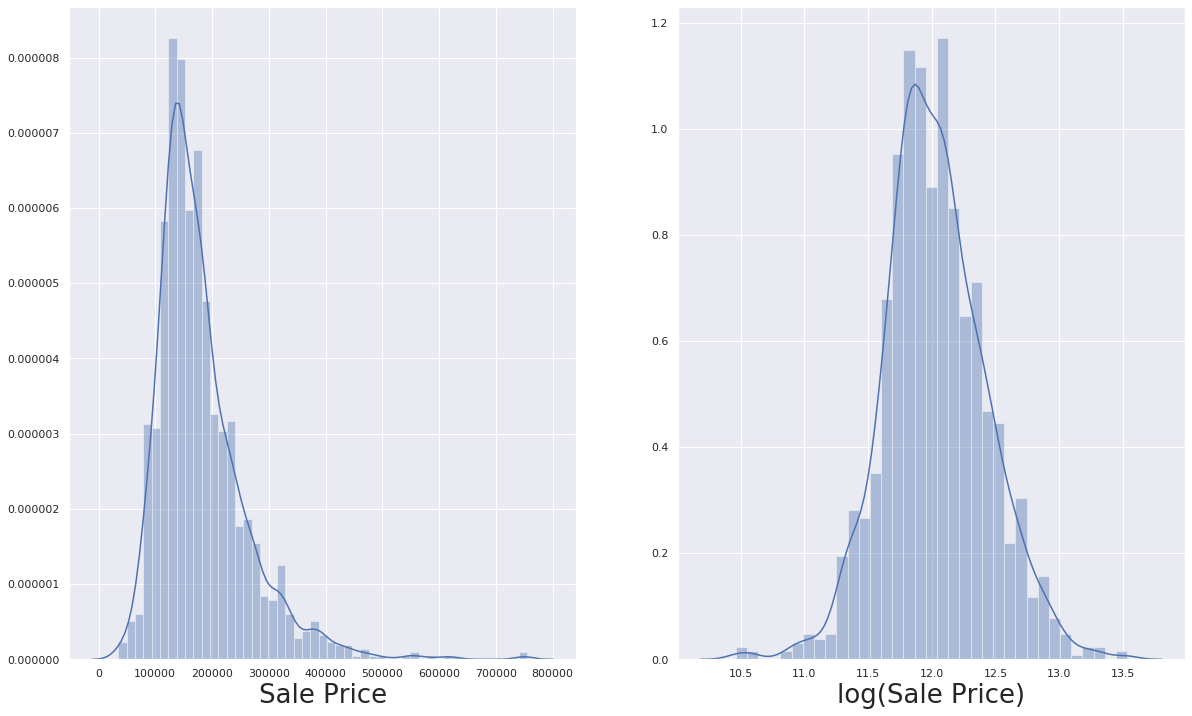

In [121]:
fig, axs = plt.subplots(ncols=2,figsize=(20,12))

sns.distplot(trainData.SalePrice,ax=axs[0])
axs[0].set_xlabel("Sale Price", fontsize=26)

sns.distplot(trainData.logSP,ax=axs[1])
axs[1].set_xlabel("log(Sale Price)",fontsize=26)

In [83]:
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.regressionplots import plot_fit

In [84]:
raw_X = trainData.OverallQual.values.reshape(-1,1)
OLS_y = trainData.SalePrice


features = sm.add_constant(raw_X)
ols_sm   = OLS(OLS_y.values,features)
raw_model    = ols_sm.fit()

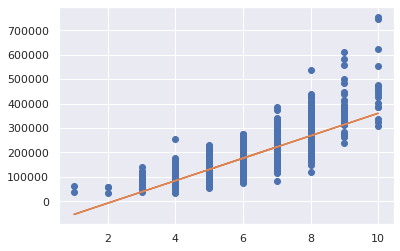

In [85]:
plt.plot(raw_X,OLS_y,"o")
plt.plot(raw_X,raw_model.fittedvalues)

In [86]:
def testPow(n):
    X = raw_X**n
    features = sm.add_constant(X)
    ols_sm   = OLS(OLS_y.values,features)
    model    = ols_sm.fit()
    return model.rsquared

pws = [testPow(i) for i in np.linspace(2.5,3.5,50)]
condPow = np.linspace(2.5,3.5,50)[np.argmax(pws)]
print(condPow)
print(np.max(pws))

3.2959183673469385
0.6995463333306919


In [87]:
scaled_X = raw_X**condPow

features = sm.add_constant(scaled_X)
ols_sm   = OLS(OLS_y.values,features)
scaled_model    = ols_sm.fit()

scaled_model.rsquared

0.6995463333306919

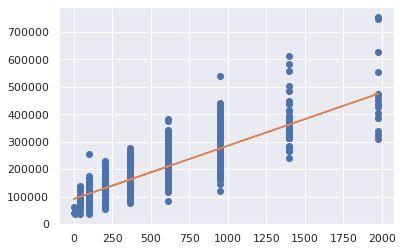

In [89]:
plt.plot(scaled_X,OLS_y,"o")
plt.plot(scaled_X,scaled_model.fittedvalues)

Text(0, 0.5, '')

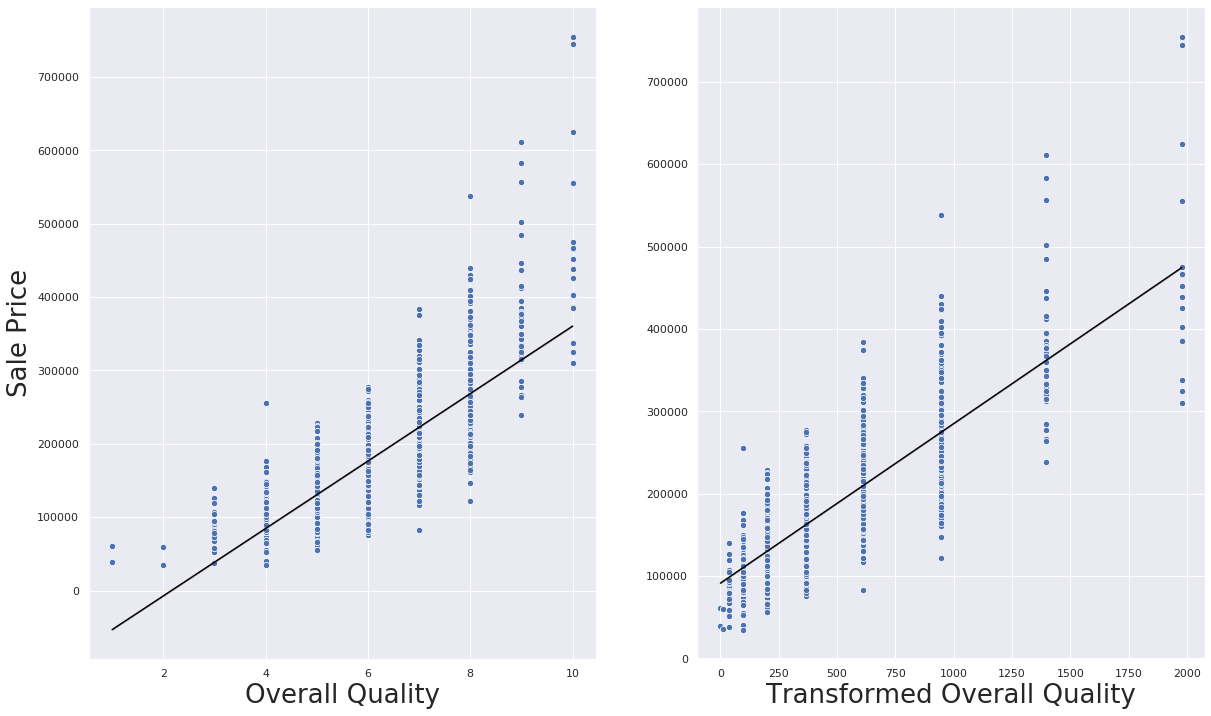

In [142]:
fig, axs = plt.subplots(ncols=2,figsize=(20,12))

sns.scatterplot(raw_X.reshape(-1,),OLS_y,s=40,ax=axs[0])
sns.lineplot(raw_X.reshape(-1,),raw_model.fittedvalues,color="black",ax=axs[0])
axs[0].set_xlabel("Overall Quality", fontsize=26)
axs[0].set_ylabel("Sale Price", fontsize=26)

sns.scatterplot(scaled_X.reshape(-1,),OLS_y,s=40,ax=axs[1])
sns.lineplot(scaled_X.reshape(-1,),scaled_model.fittedvalues, color="black",ax=axs[1])
axs[1].set_xlabel("Transformed Overall Quality",fontsize=26)
axs[1].set_ylabel("",fontsize=2)

                   mean           std  count
MSZoning                                    
C (all)    74528.000000  33791.092031     10
FV        214014.061538  52369.662067     65
RH        131558.375000  35714.118435     16
RL        191037.422977  80831.267725   1149
RM        126316.830275  48521.689833    218


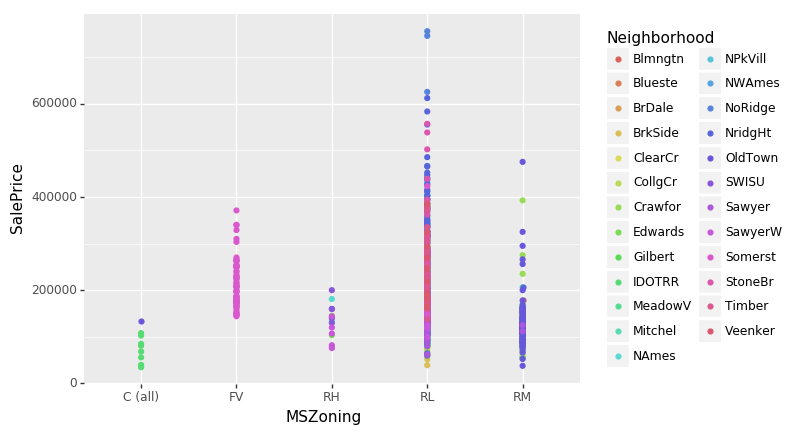

<ggplot: (-9223363303646034856)>


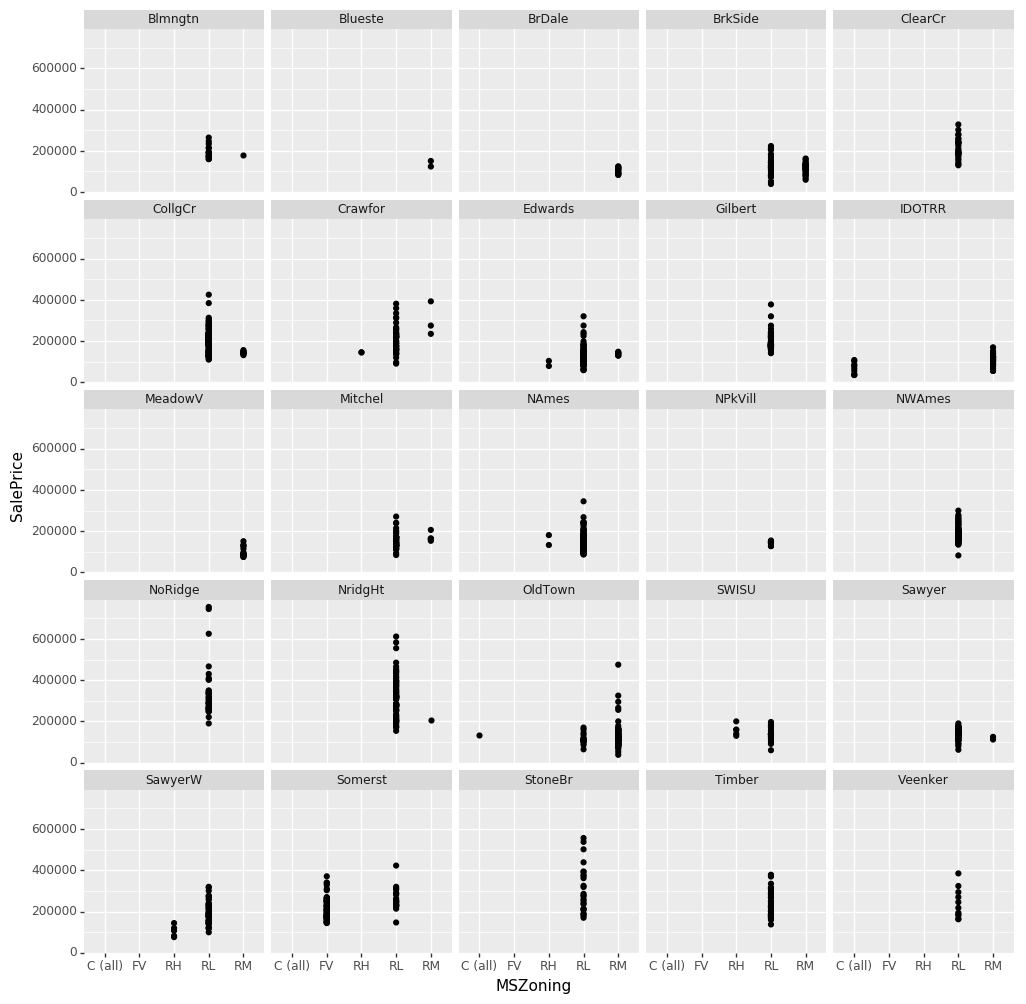

<ggplot: (-9223363303645999395)>


In [14]:
curVar = "MSZoning"
print(trainData.groupby(curVar).SalePrice.agg(["mean","std","count"]))
g1 = ggplot(trainData, aes(x=curVar,y="SalePrice")) + geom_point(aes(color="Neighborhood"))
g2 = ggplot(trainData, aes(x=curVar,y="SalePrice")) + geom_point() + facet_wrap("Neighborhood") + theme(figure_size=(12,12))

print(g1)
print(g2)

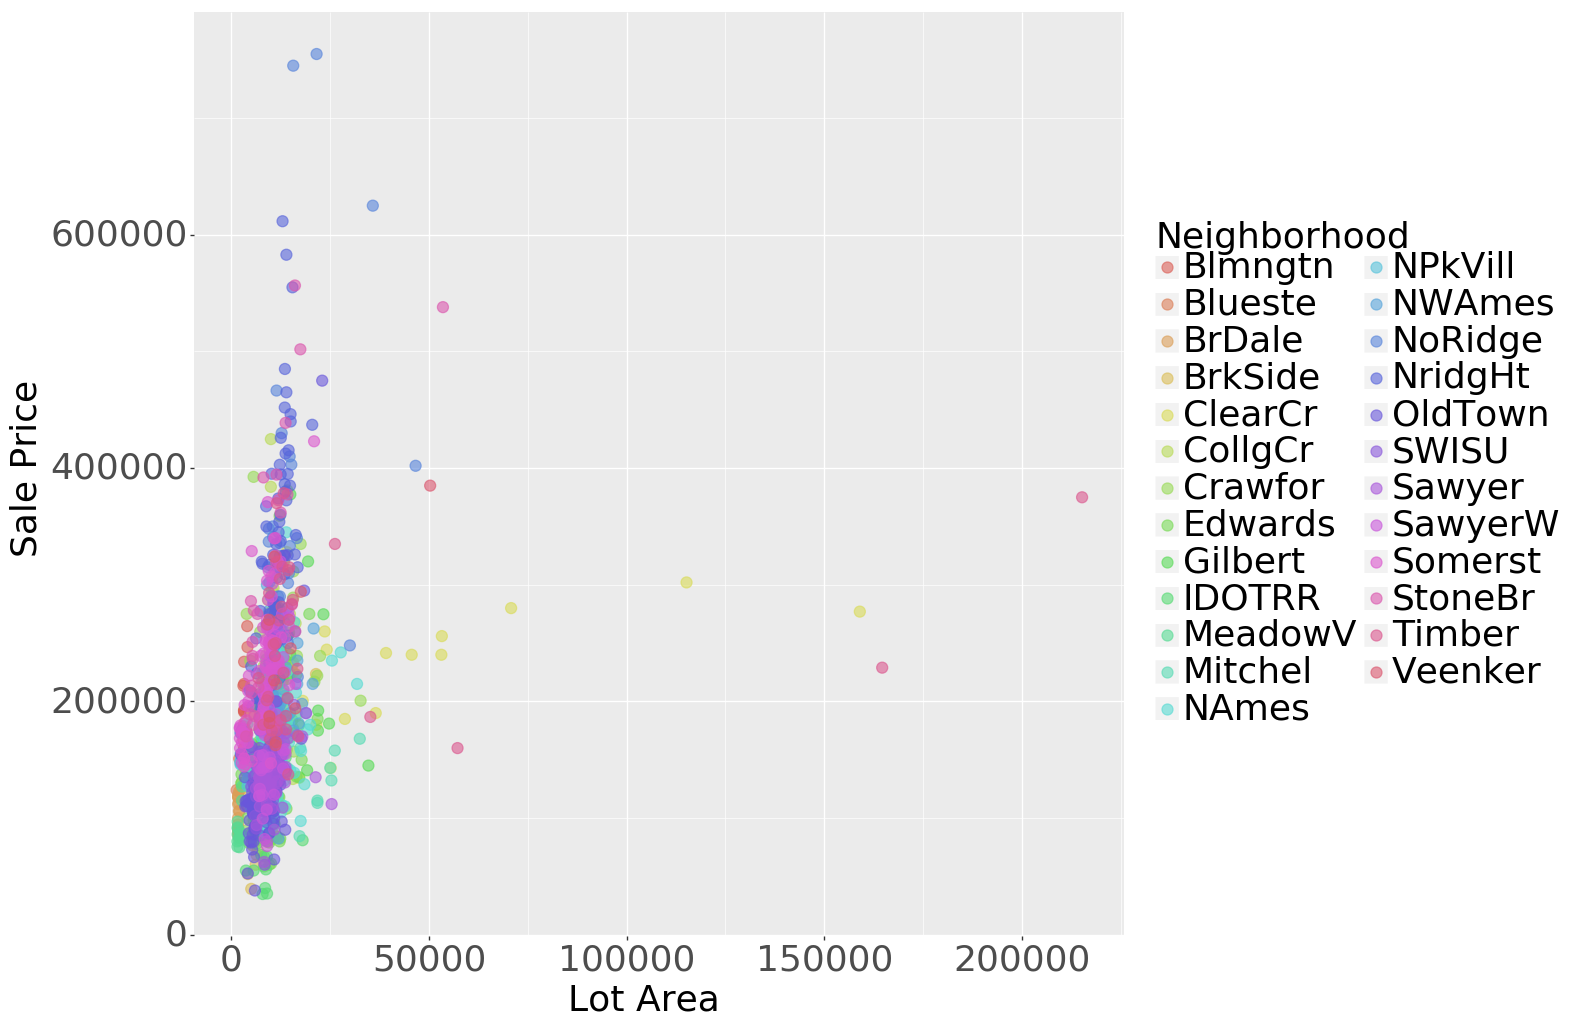

<ggplot: (8733209762466)>

In [16]:
(ggplot(trainData, aes(x="LotArea",y="SalePrice")) + geom_point(aes(color="Neighborhood"),size=4,alpha=0.6) 
 + theme(figure_size=(12,12), text=element_text(size=26)) 
 + xlab("Lot Area")) + ylab("Sale Price")

In [132]:
trainData["garageDiff"] = trainData.GarageYrBlt - trainData.YearBuilt
trainData["remoDiff"] = trainData.YearRemodAdd - trainData.YearBuilt

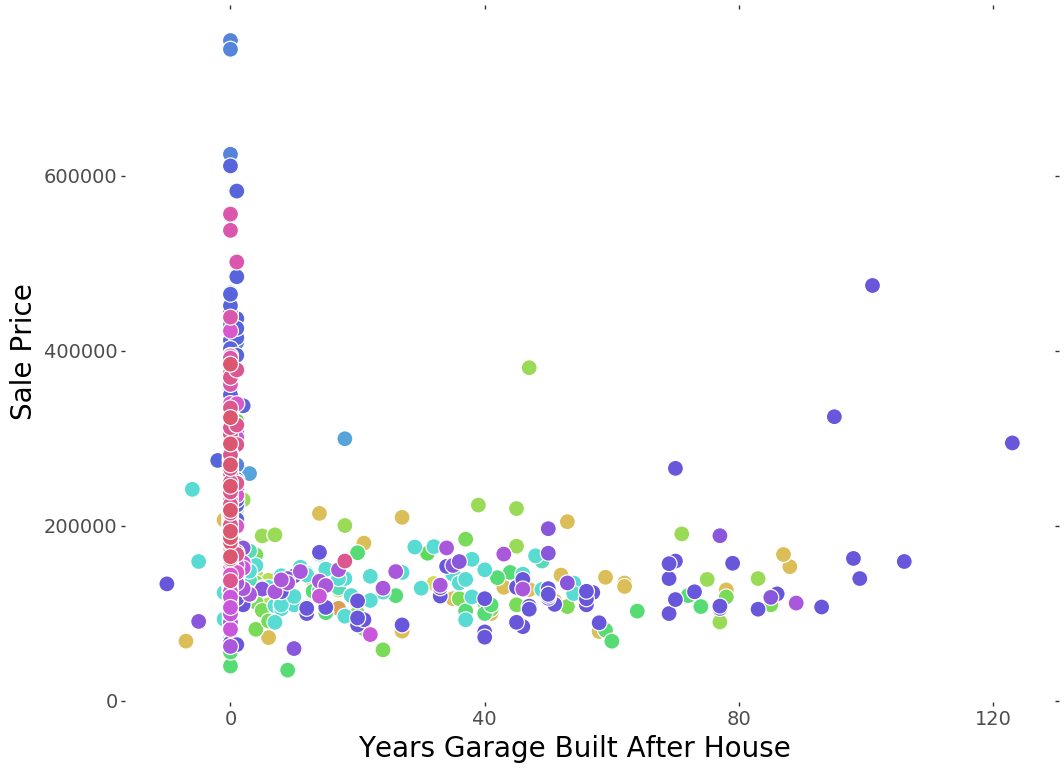

<ggplot: (8753906935707)>

In [147]:
(ggplot(trainData,aes(x="garageDiff",y="SalePrice")) 
 + geom_point(aes(fill="Neighborhood"),color="white",size=6) 
 + theme(
     legend_position="none",
     figure_size=(12,9), 
     axis_text_x = element_text(size=14),
     axis_text_y = element_text(size=14),
     axis_title_y = element_text(size=20),
     axis_title_x = element_text(size=20),
     panel_background = element_rect(fill="white")) 
 + xlab("Years Garage Built After House") + ylab("Sale Price"))

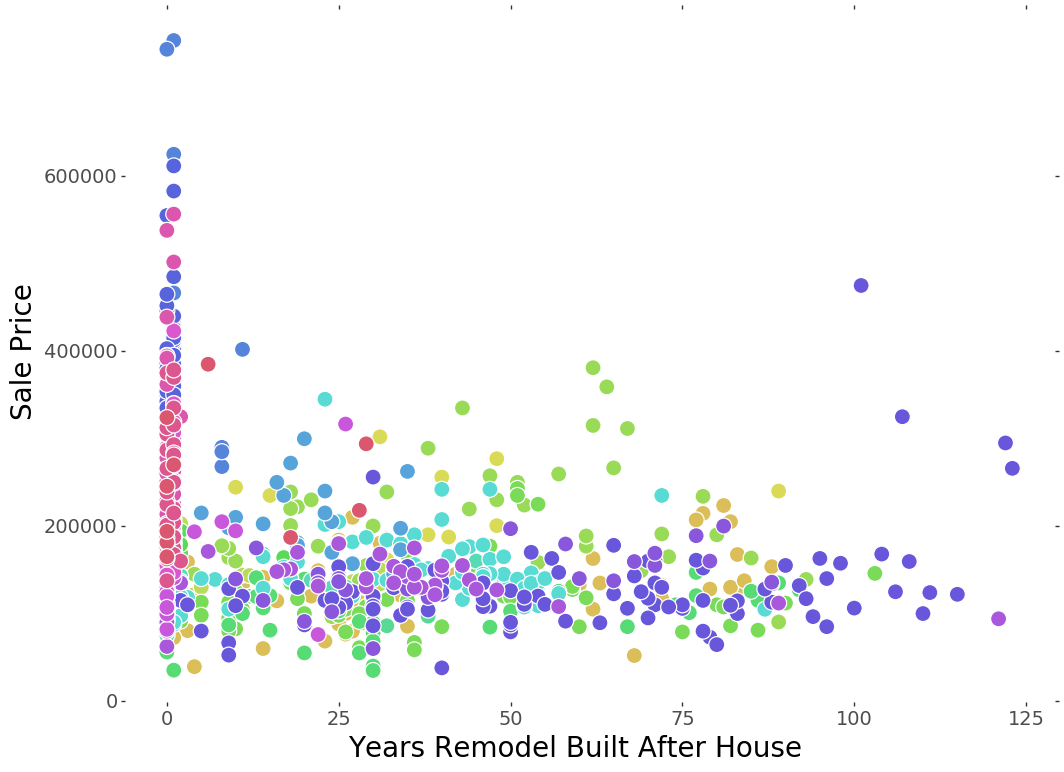

<ggplot: (8753908023942)>

In [146]:
(ggplot(trainData,aes(x="remoDiff",y="SalePrice")) 
 + geom_point(aes(fill="Neighborhood"),color="white",size=6) 
 + theme(
     legend_position="none",
     figure_size=(12,9), 
     axis_text_x = element_text(size=14),
     axis_text_y = element_text(size=14),
     axis_title_y = element_text(size=20),
     axis_title_x = element_text(size=20),
     panel_background = element_rect(fill="white")) 
 + xlab("Years Remodel Built After House") + ylab("Sale Price"))

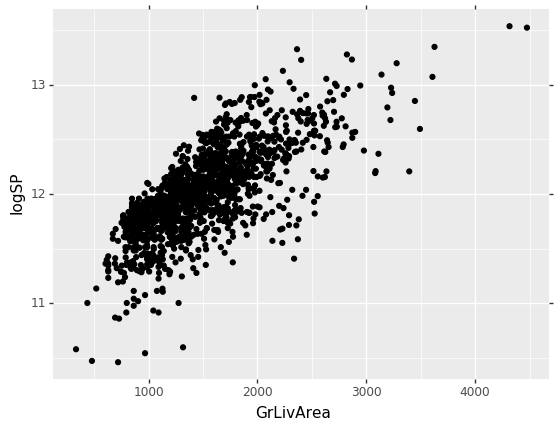

<ggplot: (8753908842767)>

In [144]:
ggplot(trainData,aes(x="GrLivArea",y="logSP")) + geom_point()

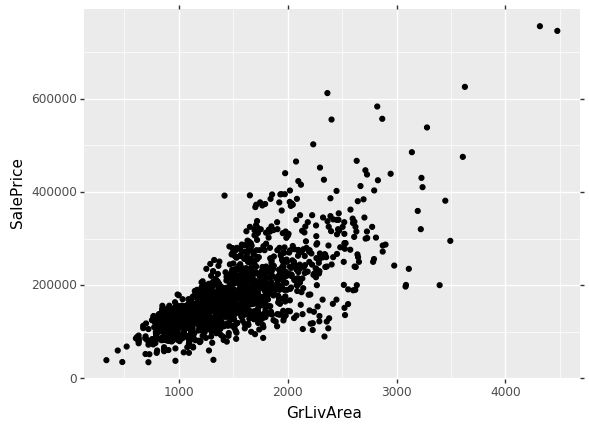

<ggplot: (8753908319047)>

In [145]:
ggplot(trainData,aes(x="GrLivArea",y="SalePrice")) + geom_point()

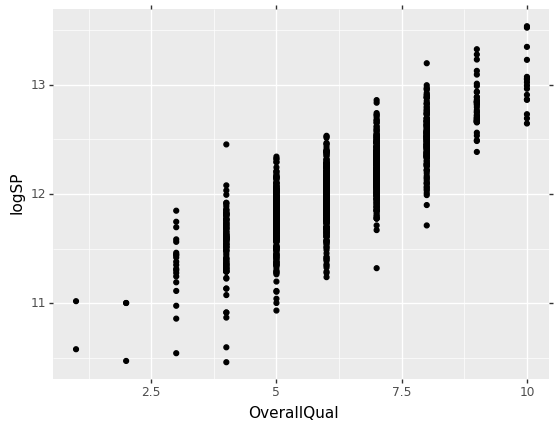

<ggplot: (8753908266486)>

In [148]:
ggplot(trainData,aes(x="OverallQual",y="logSP")) + geom_point()